In [2]:
import pandas as pd
import numpy as np
file_path = "data/VOC-ALS.xlsx" 
voc_als = pd.read_excel(file_path, header=1, engine="openpyxl")
voc_als.columns = voc_als.columns.str.strip()
print("Null Values", voc_als.isnull().sum().sum())


Null Values 0


In [3]:
#Severity Score
voc_als["Severity_Score"] = voc_als.apply(
    lambda row: 0 if row["Category"] == "HC" else 48 - row["ALSFRS-R_TotalScore"],
    axis=1
)
print(voc_als[["Category", "ALSFRS-R_TotalScore", "Severity_Score"]].head())

# Null values
print(" Null Values in Severity_Score", voc_als["Severity_Score"].isna().sum())


  Category  ALSFRS-R_TotalScore  Severity_Score
0       HC                   48               0
1       HC                   48               0
2       HC                   48               0
3       HC                   48               0
4       HC                   48               0
 Null Values in Severity_Score 0


In [4]:
#Feature Selection
voc_als_features = voc_als.iloc[:, 32:].copy()  
X = voc_als_features.drop(columns=["Severity_Score"], errors="ignore")
y = voc_als["Severity_Score"]

print("Features", X.columns.tolist())
print(f"Feature Shape {X.shape}, Target Shape: {y.shape}")


Features ['meanF0Hz_A', 'stdevF0Hz_A', 'HNR_A', 'localJitter_A', 'localShimmer_A', 'meanF0Hz_E', 'stdevF0Hz_E', 'HNR_E', 'localJitter_E', 'localShimmer_E', 'meanF0Hz_I', 'stdevF0Hz_I', 'HNR_I', 'localJitter_I', 'localShimmer_I', 'meanF0Hz_O', 'stdevF0Hz_O', 'HNR_O', 'localJitter_O', 'localShimmer_O', 'meanF0Hz_U', 'stdevF0Hz_U', 'HNR_U', 'localJitter_U', 'localShimmer_U', 'meanF0Hz_PA', 'stdevF0Hz_PA', 'HNR_PA', 'localJitter_PA', 'localShimmer_PA', 'meanF0Hz_TA', 'stdevF0Hz_TA', 'HNR_TA', 'localJitter_TA', 'localShimmer_TA', 'meanF0Hz_KA', 'stdevF0Hz_KA', 'HNR_KA', 'localJitter_KA', 'localShimmer_KA']
Feature Shape (153, 40), Target Shape: (153,)


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set {X_train.shape}")
print(f"Validation set {X_val.shape}")
print(f"Test set {X_test.shape}")



Training set (122, 40)
Validation set (15, 40)
Test set (16, 40)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=2000, max_depth=5, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
}

X_train_filtered = X_train.drop(columns=["Severity_Score", "Cantagallo_Questionnaire"], errors="ignore")
X_val_filtered = X_val.drop(columns=["Severity_Score", "Cantagallo_Questionnaire"], errors="ignore")
X_test_filtered = X_test.drop(columns=["Severity_Score", "Cantagallo_Questionnaire"], errors="ignore")

# Training and Evaluating
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    results = {}

    for dataset_name, y_true, y_pred in [
        ("Training", y_train, y_train_pred),
        ("Validation", y_val, y_val_pred),
        ("Test", y_test, y_test_pred)
    ]:
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)

        results[dataset_name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2}

        print(f"\n {model.__class__.__name__} Performance on {dataset_name}:")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"R² Score: {r2:.4f}")

    return results

full_results = {}
trained_models = {}

for name, model in models.items():
    print("\n" + "="*40)
    print(f"Training {name}")
    full_results[name] = evaluate_model(
        model, X_train_filtered, y_train, X_val_filtered, y_val, X_test_filtered, y_test
    )
    trained_models[name] = model  # Store trained models for feature importance





Training Linear Regression

 LinearRegression Performance on Training:
Mean Absolute Error (MAE): 5.5044
Mean Squared Error (MSE): 46.6025
Root Mean Squared Error (RMSE): 6.8266
R² Score: 0.4935

 LinearRegression Performance on Validation:
Mean Absolute Error (MAE): 8.0369
Mean Squared Error (MSE): 122.0870
Root Mean Squared Error (RMSE): 11.0493
R² Score: -1.2029

 LinearRegression Performance on Test:
Mean Absolute Error (MAE): 9.5277
Mean Squared Error (MSE): 170.6937
Root Mean Squared Error (RMSE): 13.0650
R² Score: -0.9852

Training Ridge Regression

 Ridge Performance on Training:
Mean Absolute Error (MAE): 5.6149
Mean Squared Error (MSE): 47.1729
Root Mean Squared Error (RMSE): 6.8683
R² Score: 0.4873

 Ridge Performance on Validation:
Mean Absolute Error (MAE): 6.8880
Mean Squared Error (MSE): 93.4728
Root Mean Squared Error (RMSE): 9.6681
R² Score: -0.6866

 Ridge Performance on Test:
Mean Absolute Error (MAE): 8.5699
Mean Squared Error (MSE): 136.7806
Root Mean Squared Erro

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

rf_model = RandomForestRegressor(
    n_estimators=2000,          # Large number of trees
    max_depth=50,               # Limit depth to prevent overfitting
    random_state=42,            # Set a fixed seed for reproducibility
    n_jobs=-1,                  # Use all available CPU cores
    bootstrap=True,             # Enable bootstrapping (default)
    max_samples=0.8             # Each tree sees x% of the training data
)


cv = KFold(n_splits=10, shuffle=True, random_state=42)  
y_pred_cv = cross_val_predict(rf_model, X_scaled_df, y, cv=cv)
mae = mean_absolute_error(y, y_pred_cv)
mse = mean_squared_error(y, y_pred_cv)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred_cv)

print("\nCross-Validation Results for Regularized Random Forest:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

rf_model.fit(X_scaled_df, y)
print("\n Final Random Forest Model Trained on Full Dataset")


Cross-Validation Results for Regularized Random Forest:
Mean Absolute Error (MAE): 7.2813
Mean Squared Error (MSE): 77.0233
Root Mean Squared Error (RMSE): 8.7763
R² Score: 0.1254

 Final Random Forest Model Trained on Full Dataset


/var/folders/xk/ynj4qgx137715cr3y98bsflw0000gn/T/ipykernel_42826/2144096030.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances[:20], y=sorted_features[:20], palette="viridis")


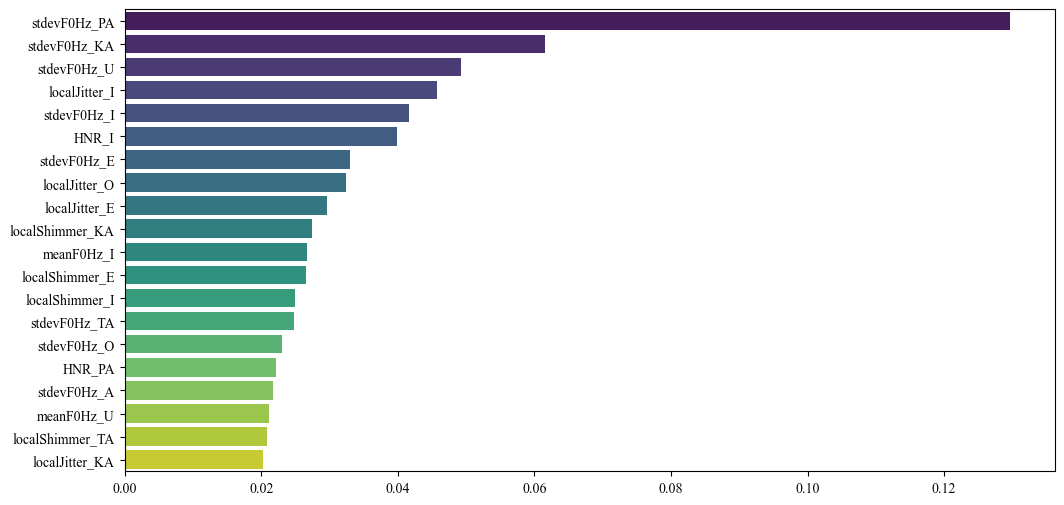

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


feature_importances = rf_model.feature_importances_
feature_names = X_scaled_df.columns
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = np.array(feature_names)[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_importances[:20], y=sorted_features[:20], palette="viridis")
plt.yticks(fontname="Times New Roman")
plt.xticks(fontname="Times New Roman")
plt.savefig("feature_importance_plot.png", dpi=300, bbox_inches='tight')
plt.show()
